In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import pyro
import pyro.distributions as dist

import functools

In [ ]:
def flip(p=0.5):
    return torch.distributions.Bernoulli(p).sample()

def pflip(p=0.5, var='flip'):
    return pyro.sample(var, dist.Bernoulli(p))

def repeat(f, n):
    return [f() for _ in range(n)]

def memoize(fn=None, **kwargs):
    if fn is None:
        return lambda _fn: memoize(_fn, **kwargs)
    return functools.lru_cache(**kwargs)(fn)

def viz(data, to_type=(lambda v: v), plot_args={}):
    # Histogram
    if type(data) in (list, torch.Tensor):
        data = [to_type(d) for d in data]
        return plt.hist(data, weights=np.ones(len(data))/float(len(data)), **plot_args)
    
    if isinstance(data, pyro.distributions.Distribution):
        d = {to_type(s): float(data.log_prob(s).exp()) for s in data.enumerate_support()}
        return plt.bar(*zip(*d.items()))
    
def Infer(model, num_samples=1000):
    posterior = pyro.infer.Importance(model, num_samples=num_samples)
    marginal = pyro.infer.EmpiricalMarginal(posterior.run())
    samples = marginal.sample(torch.Size([num_samples]))
    return samples

In [4]:
# New functions

def factor(name, value):
    """
    Like factor in webPPL, adds a scalar weight to the log-probability of the trace
    """
    value = value if torch.is_tensor(value) else torch.Tensor([value])
    d = dist.Bernoulli(logits=value)
    pyro.sample(name, d, obs=torch.ones((value.size() or 1)))
    
def condition(name, cond):
    value = (-99999 if cond else 0)
    d = dist.Bernoulli(logits=value)
    pyro.sample(name, d, obs=torch.ones(1))

# Hypothetical Reasoning with Infer

(array([153.,   0.,   0., 366.,   0.,   0., 383.,   0.,   0.,  98.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ],
       dtype=float32),
 <a list of 10 Patch objects>)

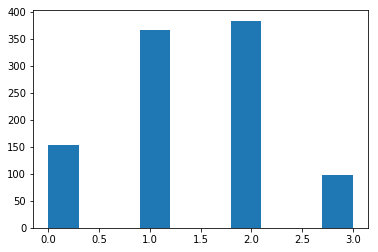

In [128]:
def model():
    A = flip()
    B = flip()
    C = flip()
    return A + B + C

# make the marginal distributions on return values explicit
num_samples = 1000

posterior = pyro.infer.Importance(model, num_samples=num_samples)
marginal = pyro.infer.EmpiricalMarginal(posterior.run())
samples = marginal.sample(torch.Size([num_samples]))

plt.hist(samples, bins=10)

(array([0.239, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.761]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

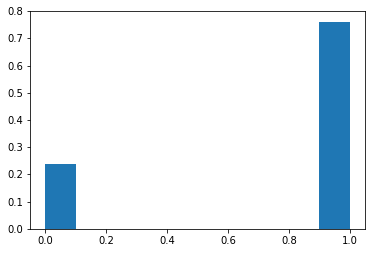

In [25]:
# TODO
#
# def model():
#     A = pflip(var='A')
#     B = pflip(var='B')
#     C = pflip(var='C')
#     D = pyro.param('D', (A+B+C))
#     return A
#
# conditioned_model = pyro.condition(model, data={'D': torch.tensor(3.0)})


def conditioned_model():
    A = flip()
    B = flip()
    C = flip()
    
    d = (A+B+C)
#     factor('D', (-99999 if d<2 else 0))
#     condition('D', (d < 2))
    D = pyro.sample('D', dist.Bernoulli(logits=(-99999 if d<2 else 0)), obs=torch.ones(1))
    return A

# make the marginal distributions on return values explicit
viz(Infer(conditioned_model, num_samples=1000))

# Rejection sampling

Is this possible?

```javascript
var model = function () {
    var A = flip()
    var B = flip()
    var C = flip()
    var D = A + B + C
    condition(D >= 2)
    return A
}
var dist = Infer({method: 'rejection', samples: 100}, model)
viz(dist)

```

# Posterior Inference

(array([0.895, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.105]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

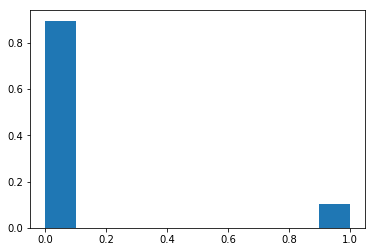

In [27]:
observed_data = True
prior = flip
likelihood = lambda h: (flip(0.9) if h else flip(0.1))

def model():
    hypothesis = prior()
    data = likelihood(hypothesis)
    condition('likelihood', data == observed_data)
    # condition(data == observed_data)
    return hypothesis

posterior = Infer(model)
viz(posterior)

(array([0.002, 0.019, 0.054, 0.128, 0.17 , 0.251, 0.234, 0.076, 0.045,
        0.021]),
 array([-0.09795149, -0.04285875,  0.01223398,  0.06732672,  0.12241945,
         0.1775122 ,  0.23260492,  0.28769767,  0.3427904 ,  0.39788315,
         0.45297587], dtype=float32),
 <a list of 10 Patch objects>)

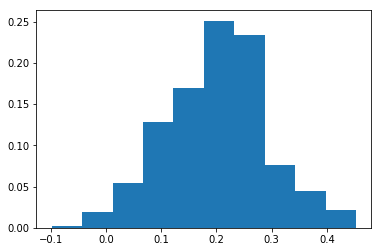

In [28]:
def model():
    true_x = dist.Normal(0, 1).sample()
    
    # WebPPL: observe(dist.Normal(true_x, 0.1), 0.2)
    pyro.sample('obs_x', dist.Normal(true_x, 0.1), obs=0.2)
    
    return true_x

viz(Infer(model))

(array([0.768, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.232]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

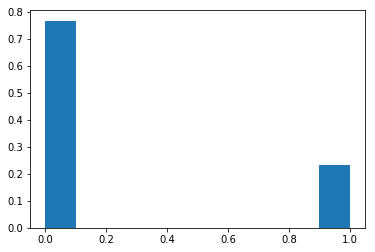

In [43]:
def f():
    A = flip()
    B = flip()
    C = flip()
    condition('D', A + B + C >= 2)
    return A

d = Infer(f)
viz(d)

(array([0.3965, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.6035]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

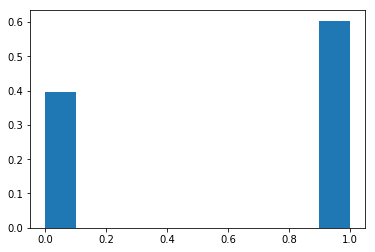

In [49]:
# TODO: why is this prob (~0.4) lower than PCM+WebPPL (~0.27)?
def f():
    A = flip()
    factor('B', (1 if A else 0))
    return A

d = Infer(f, num_samples=int(1e4))
viz(d)

# Example: Reasoning About Tug of War

In [68]:
@memoize
def strength(person):
    return abs(dist.Normal(1, 1).sample())

def lazy(person):
    return flip(1 / 3.)

def pulling(person):
    return (strength(person) / 2 if lazy(person) else strength(person))

def total_pulling(team):
    return sum(map(pulling, team))

def winner(team1, team2):
    return team1 if (total_pulling(team1) > total_pulling(team2)) else team2

[
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'tom'], ['bob', 'sue']),
    winner(['alice', 'tom'], ['bob', 'sue'])
]

[["winner(['alice', 'bob'], ['sue', 'tom'])", ['alice', 'bob']],
 ["winner(['alice', 'bob'], ['sue', 'tom'])", ['alice', 'bob']],
 ["winner(['alice', 'sue'], ['bob', 'tom'])", ['alice', 'sue']],
 ["winner(['alice', 'sue'], ['bob', 'tom'])", ['alice', 'sue']],
 ["winner(['alice', 'tom'], ['bob', 'sue'])", ['bob', 'sue']],
 ["winner(['alice', 'tom'], ['bob', 'sue'])", ['bob', 'sue']]]

(array([0.119, 0.075, 0.099, 0.1  , 0.052, 0.061, 0.049, 0.055, 0.051,
        0.036, 0.04 , 0.011, 0.034, 0.031, 0.039, 0.042, 0.029, 0.01 ,
        0.004, 0.009, 0.011, 0.007, 0.005, 0.006, 0.009, 0.001, 0.   ,
        0.   , 0.005, 0.01 ]),
 array([0.00305009, 0.09784786, 0.19264562, 0.2874434 , 0.38224116,
        0.47703895, 0.5718367 , 0.6666345 , 0.76143223, 0.85623   ,
        0.9510278 , 1.0458256 , 1.1406233 , 1.2354211 , 1.3302189 ,
        1.4250166 , 1.5198144 , 1.6146122 , 1.70941   , 1.8042077 ,
        1.8990055 , 1.9938033 , 2.088601  , 2.1833987 , 2.2781966 ,
        2.3729944 , 2.467792  , 2.56259   , 2.6573877 , 2.7521853 ,
        2.8469832 ], dtype=float32),
 <a list of 30 Patch objects>)

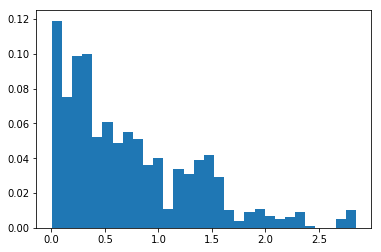

In [79]:
def model():
    
    @memoize
    def strength(person):
        return abs(dist.Normal(1, 1).sample())

    def lazy(person): 
        return flip(1 / 3.)
    
    def pulling(person): 
        return strength(person) / 2 if lazy(person) else strength(person)
    
    def total_pulling(team): 
        return sum(map(pulling, team))
    
    def winner(team1, team2): 
        return team1 if (total_pulling(team1) > total_pulling(team2)) else team2 
    
    def beat(team1, team2): 
        return winner(team1, team2) == team1

    condition('beats_1', beat(['bob', 'mary'], ['tom', 'sue']))
    condition('beats_2', beat(['bob', 'sue'],  ['tom', 'jim']))
    return strength('bob')

# {method: 'MCMC', kernel: 'MH', samples: 25000}
d = Infer(model)
# print('Expected strength: ' + expectation(d))

viz(d, plot_args={'bins': 30})

(array([0.936, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.064]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

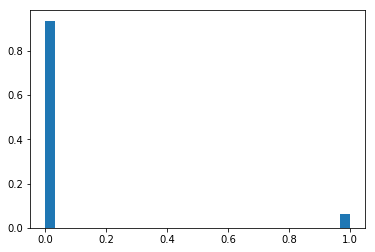

In [82]:
def model():

    @memoize
    def strength(person):
        return abs(dist.Normal(1, 1).sample())

    def lazy(person): 
        return flip(1 / 3.)
    
    def pulling(person): 
        return strength(person) / 2 if lazy(person) else strength(person)
    
    def total_pulling(team): 
        return sum(map(pulling, team))
    
    def winner(team1, team2): 
        return team1 if (total_pulling(team1) > total_pulling(team2)) else team2 
    
    def beat(team1, team2): 
        return torch.tensor(winner(team1, team2) == team1)

    condition('stronger', strength('mary') >= strength('sue'))
    condition('beats', beat(['bob'], ['jim']))
    return beat(['bob', 'mary'], ['jim', 'sue'])

d = Infer(model)
viz(d, plot_args={'bins': 30})

# Example: Inverse intuitive physics

In [4]:
import sys
sys.path.append('/Users/big/lib/PyroBPL/env/lib/python3.7/site-packages')
import pymunk

In [ ]:
# TODO

# Example: Causal Inference in Medical Diagnosis

(array([0.998, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.002]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

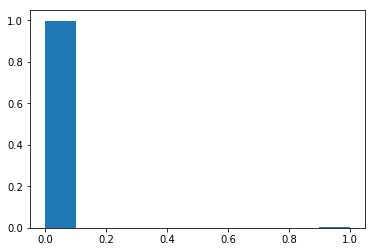

In [11]:
# TODO - results are wrong

def f():
    breast_cancer = flip(0.01)
    positive_mammogram = flip(0.8) if breast_cancer else flip(0.096)
    condition('p', positive_mammogram)
    return breast_cancer
   
d = Infer(f, num_samples=10000)
viz(d)

(array([0.936, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.064]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

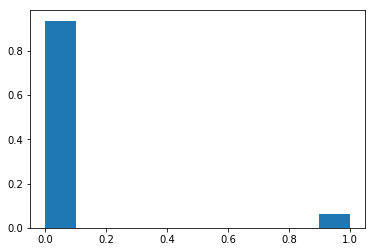

In [18]:
# TODO: also not working right..? or is WebPPL wrong???

def f():
    breast_cancer = flip(0.01)
    benign_cyst = flip(0.2)
    positive_mammogram = (breast_cancer and flip(0.8)) or (benign_cyst and flip(0.5))
    condition('p', positive_mammogram)
    return breast_cancer

d = Infer(f)
viz(d)

(array([0.998, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.002]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

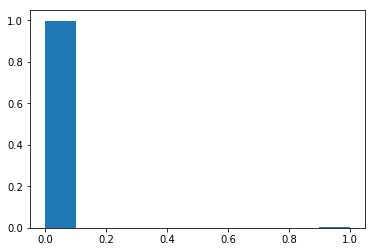

In [19]:
def f():
    lung_cancer = flip(0.01)
    TB = flip(0.005)
    cold = flip(0.2)
    stomach_flu = flip(0.1)
    other = flip(0.1)

    cough = ((cold and flip(0.5)) or
             (lung_cancer and flip(0.3)) or
             (TB and flip(0.7)) or
             (other and flip(0.01)))

    fever = ((cold and flip(0.3)) or
             (stomach_flu and flip(0.5)) or
             (TB and flip(0.2)) or
             (other and flip(0.01)))

    chest_pain = ((lung_cancer and flip(0.4)) or
                  (TB and flip(0.5)) or
                  (other and flip(0.01)))

    shortness_of_breath = ((lung_cancer and flip(0.4)) or
                           (TB and flip(0.5)) or
                           (other and flip(0.01)))

    condition('x', cough and fever and chest_pain and shortness_of_breath)
    return lung_cancer #{lung_cancer: lung_cancer, TB: TB}

d = Infer(f)
viz(d)

(array([0.986, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.014]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

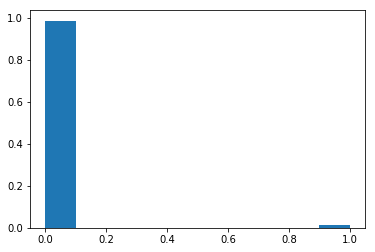

In [22]:
def f():
    works_in_hospital = flip(0.01)
    smokes = flip(0.2)
    
    lung_cancer = flip(0.01) or (smokes and flip(0.02))
    TB = flip(0.005) or (works_in_hospital and flip(0.01))
    cold = flip(0.2) or (works_in_hospital and flip(0.25))
    
    stomach_flu = flip(0.1)
    other = flip(0.1)

    cough = ((cold and flip(0.5)) or
             (lung_cancer and flip(0.3)) or
             (TB and flip(0.7)) or
             (other and flip(0.01)))

    fever = ((cold and flip(0.3)) or
             (stomach_flu and flip(0.5)) or
             (TB and flip(0.2)) or
             (other and flip(0.01)))

    chest_pain = ((lung_cancer and flip(0.4)) or
                  (TB and flip(0.5)) or
                  (other and flip(0.01)))

    shortness_of_breath = ((lung_cancer and flip(0.4)) or
                           (TB and flip(0.5)) or
                           (other and flip(0.01)))

    condition('x', cough and chest_pain and shortness_of_breath)
#     condition('x', cough and fever and chest_pain and shortness_of_breath)
    return lung_cancer #{lung_cancer: lung_cancer, TB: TB}


d = Infer(f)
viz(d)